# IMPORTS

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import logging, joblib, tqdm, itertools, operator, random, collections
import cv2
import skimage
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from cv2 import imread
from cv2 import imwrite
import scipy
from skimage.morphology import opening, disk, closing
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imageio

from sklearn.cluster import KMeans

from PIL import Image, ImageDraw, ImageFont

from functools import reduce

from collections import namedtuple


In [2]:

Point = namedtuple('Point', 'x y')

def points_adjoin(p1, p2):
    # to accept diagonal adjacency, use this form
    #return -1 <= p1.x-p2.x <= 1 and -1 <= p1.y-p2.y <= 1
    return (-1 <= p1.x-p2.x <= 1 and p1.y == p2.y or
             p1.x == p2.x and -1 <= p1.y-p2.y <= 1)

def adjoins(pts, pt):
    return any(points_adjoin(p,pt) for p in pts)

def locate_regions(datastring):
    data = datastring
    regions = []
    datapts = [Point(x,y) 
                for y in range(len(data[0]))
                    for x in range(len(data)) if data[x][y]==1]
    for dp in datapts:
        # find all adjoining regions
        adjregs = [r for r in regions if adjoins(r,dp)]
        if adjregs:
            adjregs[0].add(dp)
            if len(adjregs) > 1:
                # joining more than one reg, merge
                regions[:] = [r for r in regions if r not in adjregs]
                regions.append(reduce(set.union, adjregs))
        else:
            # not adjoining any, start a new region
            regions.append(set([dp]))
    return regions

def region_index(regs, p):
    return next((i for i,reg in enumerate(regs) if p in reg), -1)

def print_regions(regs):
    maxx = max(p.x for r in regs for p in r)
    maxy = max(p.y for r in regs for p in r)
    allregionpts = reduce(set.union, regs)
    line = np.ones((maxx+4,maxy+3)) #  empty regular list
    
    for y in range(-1,maxy+2):
        
        for x in range(-1,maxx+2):
            p = Point(x, y)
            if p in allregionpts:
                line[x][y]=1
            else:
                line[x][y]=0


    return line
# test against data set


In [18]:
# Bilate filtered image. Sharpened image helps to give a better edge approximation.
# Bilate filtered image. Sharpened image helps to give a better edge approximation.
def read_image(image):
    kk = imread(image,-1)
    #plt.figure()
    #plt.imshow(kk)
    return kk

In [4]:
def read_image_gray(image):
    bgr_img = imread(image,0) #cv2.IMREAD_GRAYSCALE
    #plt.figure()
    #plt.imshow(bgr_img)
    return bgr_img

In [20]:
def segmentation_by_color(image,th):
    ret,im_thresh= cv2.threshold(image,th,255,cv2.THRESH_BINARY_INV)
    #print (init)
    '''
    alpha Higher values make snake contract faster
    beta Highervalue make snake smoother
    Gamma Timestepping parameter
    '''
    #plt.figure()
    #plt.imshow(im_thresh)
    return im_thresh

In [6]:
#smooth and threshold as image has compression artifacts (jpg)
def gaus_filter(image):
    im = ndimage.gaussian_filter(image/2, 0.06)
    im[im<10]=0
    im[im>=10]=255
    blobs, number_of_blobs = ndimage.label(im)

    #plt.figure()
    #plt.imshow(blobs)
    
    return blobs

In [7]:
def polarisation(blobs):
    a=blobs/255

    a=np.where(a==0, 2, a)
    a=np.where(a!=2, 0, a)
    a=np.where(a==2, 1, a)
    
        
    #plt.figure()
    #plt.imshow(a)
    
    return a

In [8]:
def region_detection(a):
    regs = locate_regions(a)

    #line = print_regions(regs)

    #plt.figure(figsize = (20,10))
    #plt.imshow(line)

    print("Number of HOUSES FOUND : % 3d"%(len(regs)))
    return regs

In [16]:
def count_regions_and_plot(regs,size,begin,im):  
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.imshow(im)
    size_thr=size
    j=0
    for reg,x_beg in zip(regs,begin):
        if len(reg)>0:
            for i,r in enumerate(reg):
                size_reg = len(r)
                if size_reg > size_thr:
            
                    pixels_x = [p.y for p in r]
                    pixels_y = [p.x+x_beg  for p in r]
            
                    m_x = np.mean(pixels_x)
                    m_y = np.mean(pixels_y)
                    
                    #print(i,m_x,m_y)
            
                    r = max([(max(pixels_x)-min(pixels_x)),(max(pixels_y)-min(pixels_y)),4])
            
                    s = np.linspace(0, 2*np.pi, int(r/2))
            
                    c = m_x + 3*np.cos(s)
                    d = m_y + 3*np.sin(s)
                    init = np.array([c, d]).T
                    #snake = active_contour(kk, init)
            
                    ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
                    #ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
            
                    # ax.set_xticks([]), ax.set_yticks([])
                    #ax.axis([0, bgr_img.shape[1], bgr_img.shape[0], 0])
            
                    j += 1
            
            

    print("Number of HOUSES FOUND WITH SIZE FILTER%1d pixels: % 3d"%(size_thr,j))
    plt.show()          




Computing image nº 0:   0%|          | 0/9 [00:00<?, ?it/s]

high density image density: 18.102296 




Computing image nº 0:  11%|█         | 1/9 [00:01<00:08,  1.10s/it]

Number of HOUSES FOUND:  33




Computing image nº 0:  22%|██▏       | 2/9 [00:02<00:08,  1.24s/it]

Number of HOUSES FOUND:  42




Computing image nº 0:  33%|███▎      | 3/9 [00:03<00:06,  1.17s/it]

Number of HOUSES FOUND:  40




Computing image nº 0:  44%|████▍     | 4/9 [00:05<00:07,  1.41s/it]

Number of HOUSES FOUND:  81




Computing image nº 0:  56%|█████▌    | 5/9 [00:06<00:05,  1.30s/it]

Number of HOUSES FOUND:  35




Computing image nº 0:  67%|██████▋   | 6/9 [00:07<00:03,  1.19s/it]

Number of HOUSES FOUND:  26




Computing image nº 0:  78%|███████▊  | 7/9 [00:08<00:02,  1.17s/it]

Number of HOUSES FOUND:  37


KeyboardInterrupt: 

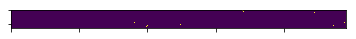

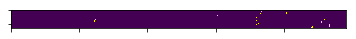

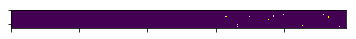

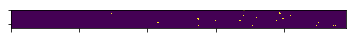

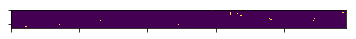

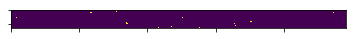

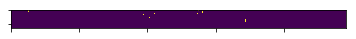

In [44]:
size_pixel_region=4
image ='8_cropped.png'

im=read_image(image)
gr_image = read_image_gray(image)

s_image = segmentation_by_color(gr_image,180)
blobs = gaus_filter(s_image)
a = polarisation(blobs)
#a = polarisation(s_image)

p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
n=max(int(p_1*200),1)

b=1

if(p_1>0.03):
    images = [gr_image[int(i*len(gr_image)/n):int((i+1)*len(gr_image)/n)] for i in range(2)]
    a_s = []
    b=2
    for im_s in images:
        s_image = segmentation_by_color(gr_image,180)
        blobs = gaus_filter(s_image)
        a=polarisation(blobs)
        denisty = p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
        
        if(denisty>0.03):
            
            s_image = segmentation_by_color(gr_image,210)
            blobs = gaus_filter(s_image)
            b=polarisation(blobs)
            a_s.append(b)
            
        else:
            a_s.append(a)
    
    print('high density image density: %3f '%(p_1*100))
    
else:
    print('low density image density: %3f '%(p_1*100))


regs = []
begin = []
z=0

for t,a in enumerate(a_s):
    p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
    n=max(int(p_1*160),1)
    
    for chop in tqdm.tqdm([a[int(i*len(a)/n):int((i+1)*len(a)/n)] for i in range(n)],
                          desc = 'Computing image nº %1d'% ( z )):
    
        reg = locate_regions(chop) 
                                              
        regs.append(reg)
        begin.append((t+1)*z*len(a)/n)
        z+=1
    
        f, ax = plt.subplots()
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(chop)
    
        print("Number of HOUSES FOUND: % 3d"%(len(reg)))

if len(regs)>0:
    count_regions_and_plot(regs,size_pixel_region,begin,im)


# LOOP for images

Number of HOUSES FOUND :   2
Number of HOUSES FOUND WITH SIZE FILTER  4 pixels:   1


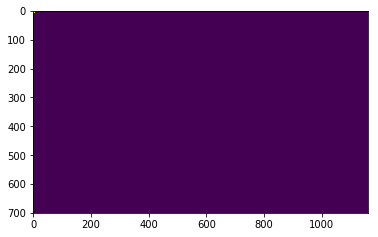

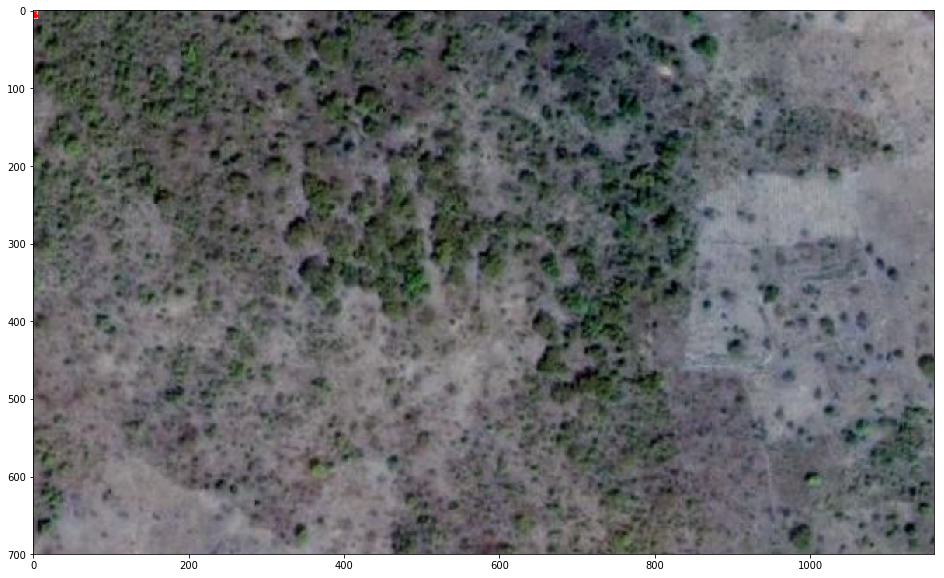

Number of HOUSES FOUND :   9
Number of HOUSES FOUND WITH SIZE FILTER  4 pixels:   1


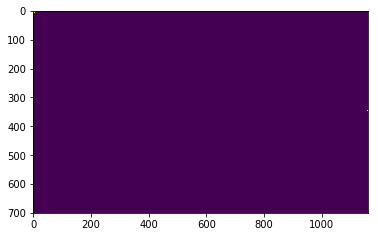

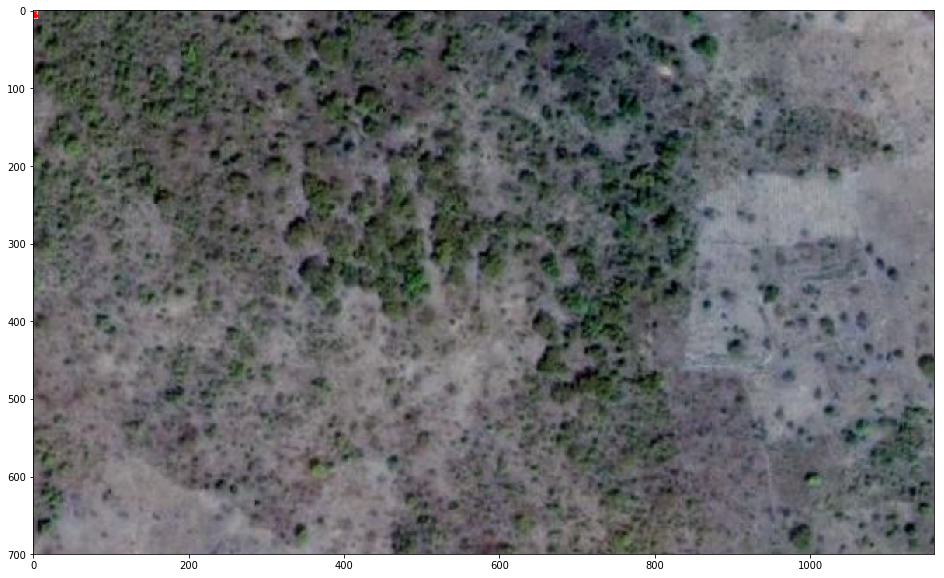

Number of HOUSES FOUND :  31
Number of HOUSES FOUND WITH SIZE FILTER  4 pixels:  10


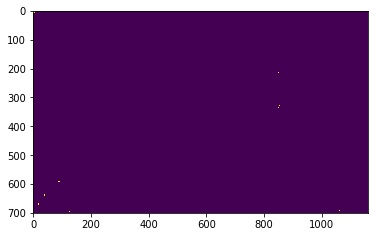

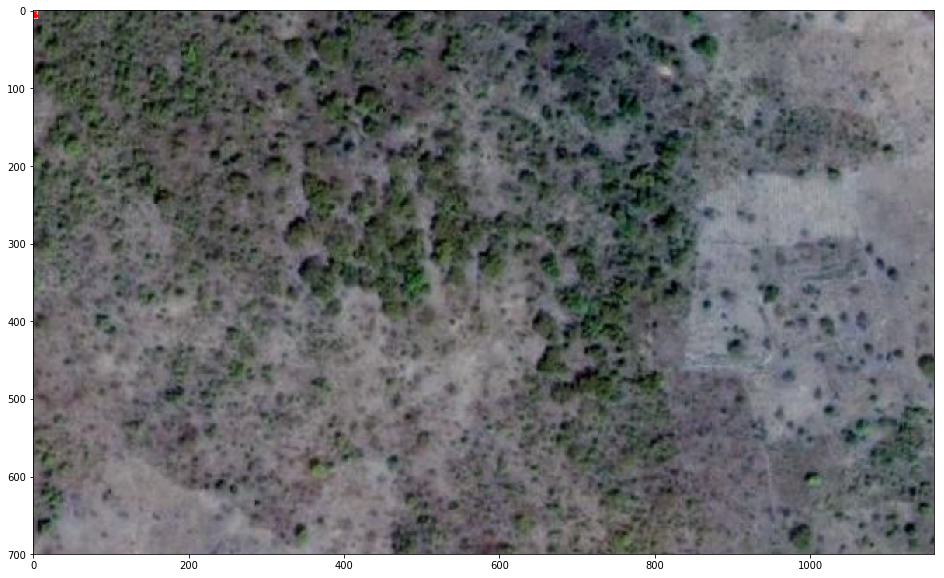

Number of HOUSES FOUND :  11
Number of HOUSES FOUND WITH SIZE FILTER  4 pixels:  10


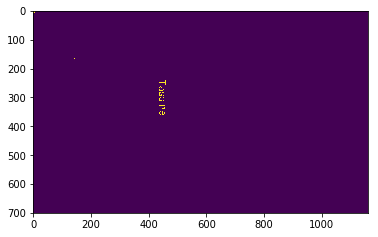

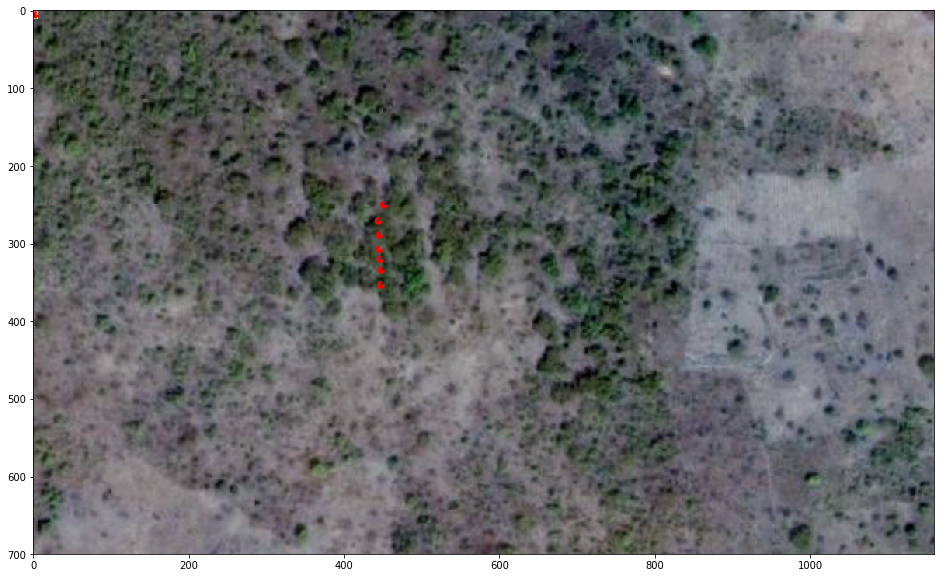

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [106]:
size_pixel_region=4
for image in [str(i+2)+'_cropped.png' for i in range(6)]:

    #read_image(image)
    gr_image = read_image_gray(image)
    s_image = segmentation_by_color(gr_image)
    blobs = gaus_filter(s_image)
    a = polarisation(blobs)
    
    p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
    n=int(p_1*160)
    
    regs = []
    begin = []
    z=0
    for chop in [a[int(i*len(a)/n):int((i+1)*len(a)/n)] for i in range(n)]:
        reg=locate_regions(chop)
        regs.append(reg)
        begin.append(z*len(a)/n)
        z+=1
        
        f, ax = plt.subplots()
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(chop)
    
        print("Number of HOUSES FOUND : % 3d"%(len(reg)))
    
    if len(regs)>0:
        count_regions_and_plot(regs,size_pixel_region,begin)


## VERSION FOR TESTING

In [45]:
image = '8_cropped.png'

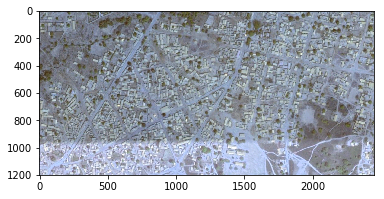

In [46]:
kk = imread(image,-1)
plt.figure()
plt.imshow(kk)

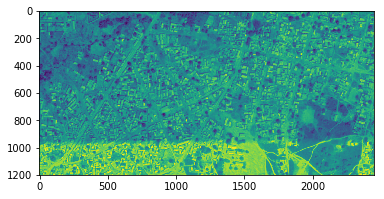

In [47]:
bgr_img = imread(image,0) #cv2.IMREAD_GRAYSCALE
plt.figure()
plt.imshow(bgr_img)

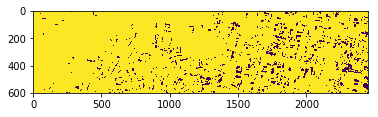

In [51]:
ret,im_thresh= cv2.threshold(bgr_img[0:int(len(bgr_img)/2)],180,255,cv2.THRESH_BINARY_INV)

plt.figure()
plt.imshow(im_thresh)

In [53]:
np.count_nonzero(im_thresh==1)/(np.count_nonzero(im_thresh==1)+np.count_nonzero(im_thresh==0))

0.0

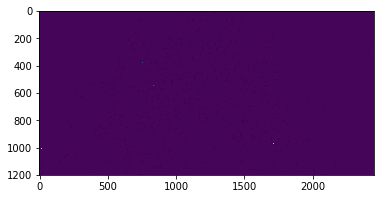

In [231]:
im = ndimage.gaussian_filter(im_thresh, 0.006)
im[im<10]=0
im[im>=10]=255
blobs, number_of_blobs = ndimage.label(im)
plt.figure()
plt.imshow(blobs)

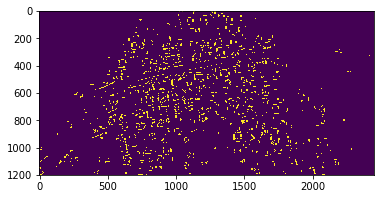

In [232]:
a=blobs/255
a=np.where(a==0, 2, a)
a=np.where(a!=2, 0, a)
a=np.where(a==2, 1, a)  
plt.figure()
plt.imshow(a)

In [233]:
np.count_nonzero(a == 1)

117399

In [234]:
np.count_nonzero(a == 0)

2820151

In [235]:
np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))

0.039964936767033755

## When there is high density of dots, locate regions does not work well O(n^3) algorithm divide image to get faster resutls

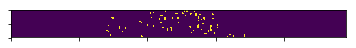

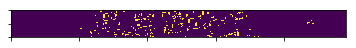

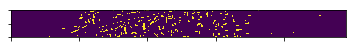

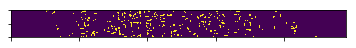

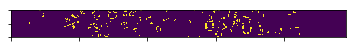

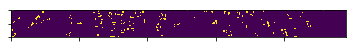

In [236]:
p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
n=int(p_1*160)
for chop in [a[int(i*len(a)/n):int((i+1)*len(a)/n)] for i in range(n)]:
    f, ax = plt.subplots()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(chop)

Number of HOUSES FOUND :  112
Number of HOUSES FOUND :  360
Number of HOUSES FOUND :  405
Number of HOUSES FOUND :  404
Number of HOUSES FOUND :  333
Number of HOUSES FOUND :  267
Number of HOUSES FOUND WITH SIZE FILTER4 pixels:  1388


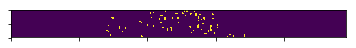

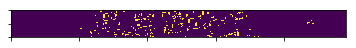

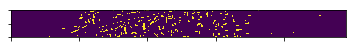

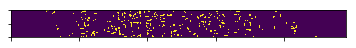

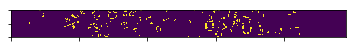

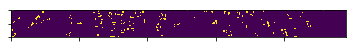

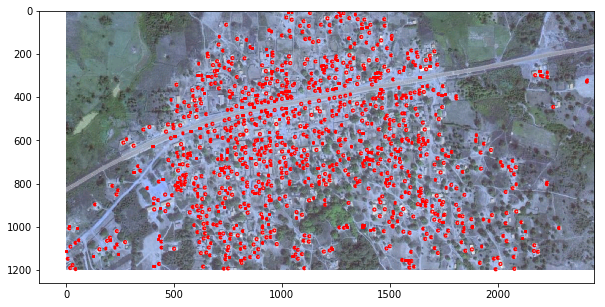

In [237]:
p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
n=int(p_1*160)

regs = []
begin = []
z=0
for chop in [a[int(i*len(a)/n):int((i+1)*len(a)/n)] for i in range(n)]:
    reg=locate_regions(chop)
    regs.append(reg)
    begin.append(z*len(a)/n)
    z+=1
    
    f, ax = plt.subplots()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(chop)

    print("Number of HOUSES FOUND : % 3d"%(len(reg)))


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.imshow(kk)
size_thr=4
j=0
    
for reg,x_beg in zip(regs,begin):
    for i,r in enumerate(reg):
        size_reg = len(r)
        if size_reg > size_thr:
    
            pixels_x = [p.y for p in r]
            pixels_y = [p.x+x_beg  for p in r]
    
            m_x = np.mean(pixels_x)
            m_y = np.mean(pixels_y)
            
            #print(i,m_x,m_y)
    
            r = max([(max(pixels_x)-min(pixels_x)),(max(pixels_y)-min(pixels_y)),4])
    
            s = np.linspace(0, 2*np.pi, int(r/2))
    
            c = m_x + 3*np.cos(s)
            d = m_y + 3*np.sin(s)
            init = np.array([c, d]).T
            #snake = active_contour(kk, init)
    
            ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
            #ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
    
            # ax.set_xticks([]), ax.set_yticks([])
            #ax.axis([0, bgr_img.shape[1], bgr_img.shape[0], 0])
    
            j += 1
    
    
print("Number of HOUSES FOUND WITH SIZE FILTER%1d pixels: % 3d"%(size_thr,j))
plt.show()          

## OLD METHOD OF DOING IT 

Number of HOUSES FOUND WITH SIZE FILTER4 pixels:   1


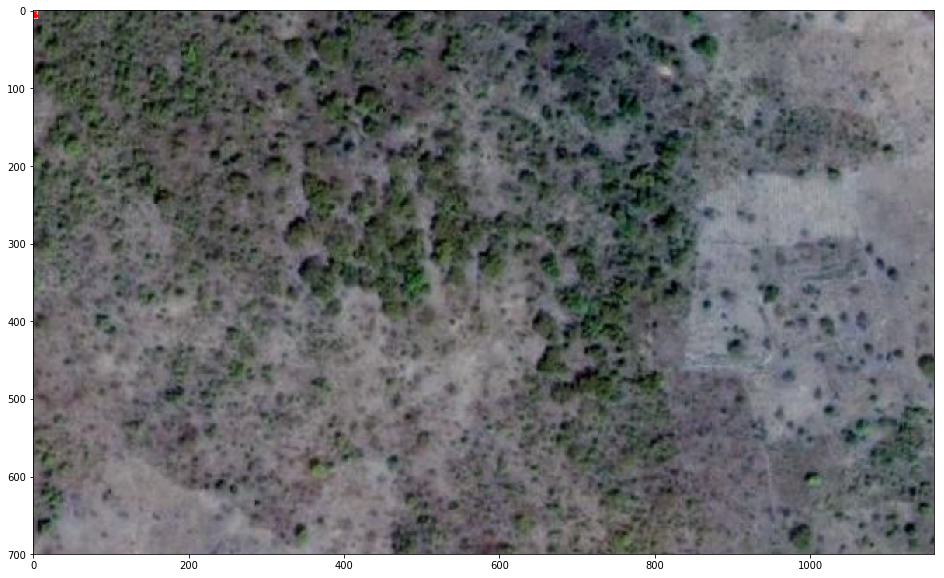

In [105]:
 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.imshow(kk)
size_thr=4
j=0
for i,r in enumerate(regs):
    size_reg = len(r)
    if size_reg > size_thr:

        pixels_x = [p.y for p in r]
        pixels_y = [p.x for p in r]

        m_x = np.mean(pixels_x)
        m_y = np.mean(pixels_y)

        r = max([(max(pixels_x)-min(pixels_x)),(max(pixels_y)-min(pixels_y)),4])

        s = np.linspace(0, 2*np.pi, int(r/2))

        c = m_x + 3*np.cos(s)
        d = m_y + 3*np.sin(s)
        init = np.array([c, d]).T
        #snake = active_contour(kk, init)

        ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
        ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)

        # ax.set_xticks([]), ax.set_yticks([])
        #ax.axis([0, bgr_img.shape[1], bgr_img.shape[0], 0])

        j += 1


print("Number of HOUSES FOUND WITH SIZE FILTER%1d pixels: % 3d"%(size_thr,j))
plt.show()          


In [108]:
green = np.uint8([[[227,220,208]]])
hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
hsv_green

array([[[101,  21, 227]]], dtype=uint8)

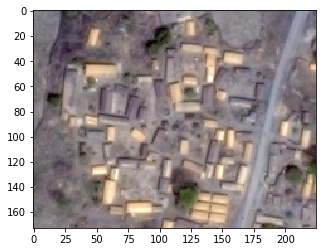

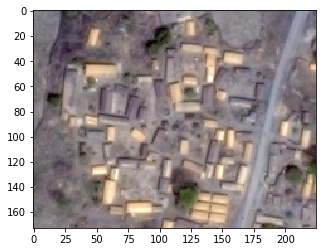

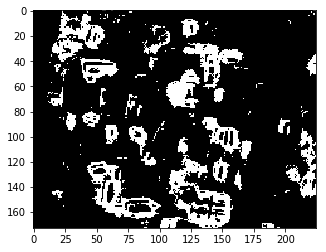

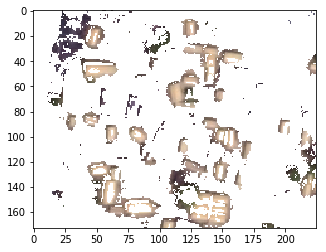

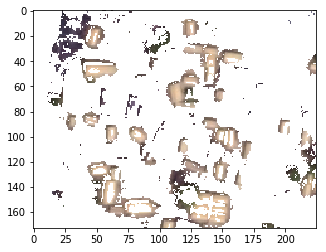

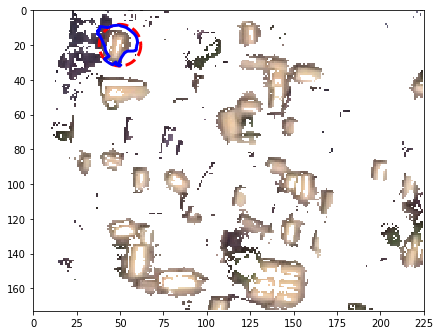

In [107]:
# Bilate filtered image. Sharpened image helps to give a better edge approximation.
bgr_img = imread('7_cropped.png',-1)

plt.figure()
plt.imshow(bgr_img)


frame = bgr_img

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# define range of blue color in HSV

lower_blue = np.array([106-80,10,50-5])
upper_blue = np.array([107+80,  81+5, 234+5])

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(frame,frame, mask= mask)

plt.figure()
plt.imshow(frame)

plt.figure()
plt.imshow(mask)

plt.figure()
plt.imshow(res)

img = res

s = np.linspace(0, 2*np.pi, 40)
x =  50 + 12*np.cos(s)
y = 20 + 12*np.sin(s)
init = np.array([x, y]).T
#print (init)
'''
alpha Higher values make snake contract faster
beta Highervalue make snake smoother
Gamma Timestepping parameter
'''


snake = active_contour(img, init,alpha=0.006)

plt.figure()
plt.imshow(img)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.gray()
ax.imshow(img)





ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
# ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
# plt.imshow(img, cmap='gray')
plt.show()

In [5]:

def equalize(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img


def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

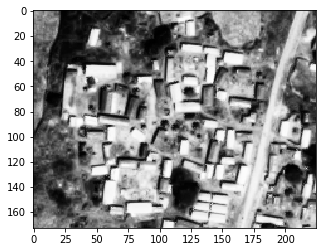

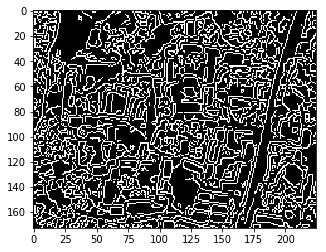

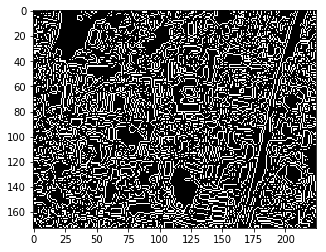

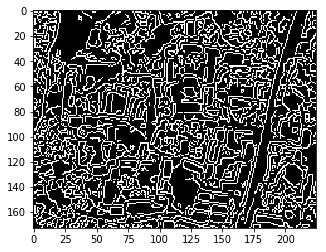

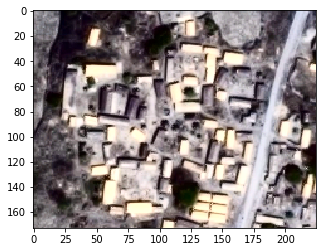

In [16]:
eq = imread('7_cropped.png')
x=equalize(eq)
gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
kernel_sharp = np.array((
         [-2, -2, -2],
         [-2, 17, -2],
         [-2, -2, -2]), dtype='int')



auto2 = auto_canny(x)
im1=cv2.filter2D(auto2, -1, kernel=kernel_sharp)
canny = auto_canny(im1)
plt.figure()
plt.imshow(auto2, cmap='gray')
plt.show()
plt.imshow(canny, cmap='gray')
plt.show()
plt.imshow(im1, cmap='gray')
plt.show()

plt.imshow(im_eq, cmap='gray')
plt.show()

[[183.          33.        ]
 [182.99802213  33.62894333]
 [182.99208861  34.25786178]
 ...
 [182.99208861  31.74213822]
 [182.99802213  32.37105667]
 [183.          33.        ]]


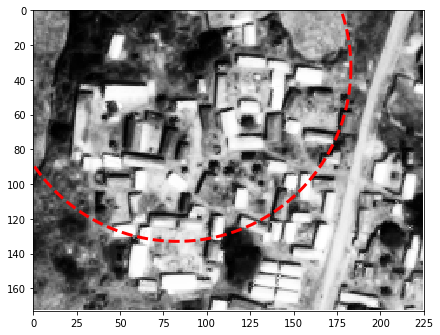

In [19]:
img = rgb2gray(eq)

s = np.linspace(0, 2*np.pi, 1000)
x = 83 + 100*np.cos(s)
y = 33 + 100*np.sin(s)
init = np.array([x, y]).T
print (init)
'''
alpha Higher values make snake contract faster
beta Highervalue make snake smoother
Gamma Timestepping parameter
'''
snake = active_contour(img, init, alpha=-1, beta=7, gamma=0.001, max_iterations=500)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.gray()
ax.imshow(img)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
# ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
# plt.imshow(img, cmap='gray')
plt.show()


In [27]:

def createLineIterator(P1, P2, im):
    """
    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])
    """
    imageH = im.shape[0]
    imageW = im.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    # difference and absolute difference between points
    # used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    # predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa, dXa), 3), dtype=np.float32)
    itbuffer.fill(np.nan)

    # Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X:  # vertical line segment
        itbuffer[:, 0] = P1X
        if negY:
            itbuffer[:, 1] = np.arange(P1Y - 1, P1Y - dYa - 1, -1)
        else:
            itbuffer[:, 1] = np.arange(P1Y + 1, P1Y + dYa + 1)
    elif P1Y == P2Y:  # horizontal line segment
        itbuffer[:, 1] = P1Y
        if negX:
            itbuffer[:, 0] = np.arange(P1X - 1, P1X - dXa - 1, -1)
        else:
            itbuffer[:, 0] = np.arange(P1X + 1, P1X + dXa + 1)
    else:  # diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = float(dX) / float(dY)
            if negY:
                itbuffer[:, 1] = np.arange(P1Y - 1, P1Y - dYa - 1, -1)
            else:
                itbuffer[:, 1] = np.arange(P1Y + 1, P1Y + dYa + 1)
            itbuffer[:, 0] = (slope * (itbuffer[:, 1] - P1Y)).astype(np.int) + P1X
        else:
            slope = float(dY) / float(dX)
            if negX:
                itbuffer[:, 0] = np.arange(P1X - 1, P1X - dXa - 1, -1)
            else:
                itbuffer[:, 0] = np.arange(P1X + 1, P1X + dXa + 1)
            itbuffer[:, 1] = (slope * (itbuffer[:, 0] - P1X)).astype(np.int) + P1Y

    # Remove points outside of image
    colX = itbuffer[:, 0]
    colY = itbuffer[:, 1]
    itbuffer = itbuffer[(colX >= 0) & (colY >= 0) & (colX < imageW) & (colY < imageH)]

    # Get intensities from img ndarray
    itbuffer[:, 2] = im[itbuffer[:, 1].astype(np.uint), itbuffer[:, 0].astype(np.uint)]

    return itbuffer



In [30]:

im = eq
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)   # 1st image use
# img = cv2.bitwise_not(img)

rows, cols = img.shape
white_img = cv2.bitwise_not(np.zeros(im.shape, np.uint8))
white_polygon = cv2.bitwise_not(np.zeros(im.shape, np.uint8))
white_gray = cv2.cvtColor(white_img, cv2.COLOR_BGR2GRAY)

v = np.median(img)
sigma = 0.33
lower_thresh = int(max(0, (1.0 - sigma) * v))
upper_thresh = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(img, lower_thresh, upper_thresh)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 30)
lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))

kmeans = KMeans(n_clusters=20).fit(lines)

for line in kmeans.cluster_centers_:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)
    cv2.line(white_gray, (x1, y1), (x2, y2), 0, 2)

    pixels = createLineIterator((x1, y1), (x2, y2), img)
    pixels = pixels.astype(int)
    pixel_len = len(pixels)

    for i in range(pixel_len):
        x, y, intensity = pixels[i]
        if 0 < y < rows - 1 and 0 < x < cols - 1:
            # patch = edges[x - k_row/2: x + k_row/2,
            #         y - k_col/2: y + k_col/2]
            sum_patch = edges[y, x] + edges[y - 1, x] + edges[y + 1, x] + edges[y, x - 1] + edges[y - 1, x - 1] + edges[
                y + 1, x - 1] + edges[y, x + 1] + edges[y - 1, x + 1] + edges[y + 1, x + 1]
            if sum_patch > 0:
                img[y, x] = 255
    
x1 = []
y1 = []
m = np.sort(m)
c = np.sort(c)
print (m, c)
for i in range(len(m)-1):
    for j in range(len(c)-1):
        if m[i] - m[i+1] != 0:
            x = ((c[j + 1] - c[j]) / (m[i] - m[i + 1]))
            y = (((m[i]*c[i+1]) - (m[i+1]*c[j])) / (m[i] - m[i+1]))
            if 0 < x < cols and 0 < y < rows:
                x1.append(x)
                y1.append(y)
x1 = np.array(x1)
y1 = np.array(y1)
intersect = (np.column_stack((x1, y1)))
print (intersect)


for i, j, k in zip(r, c, s):
    r[i] = x1*c[j] + y1*s[k]

contours = cv2.findContours(white_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

for cnt in contours:
    cv2.drawContours(white_polygon, cnt, 0, 0, -1)
    man = []
    intense = []
    for col in range(cols):
        for row in range(rows):
            if cv2.pointPolygonTest(cnt, (col, row), False) == 1:
                man.append((row, col))
    for k in man:
        intense.append(im[k])
    intensity = mean(intense)
    # print (intensity)
    if intensity > 170:
        cv2.drawContours(white_polygon, [cnt], 0, 0, -1)

    # mean_val = np.mean(cnt)
    # if mean_val < 120:
    #     img[cnt] = 255
# man = map(int, man)
# for i, j in zip(contours, man):
#     if j < 90:
#         cv2.drawContours(img, i, 0, thickness=-1, color=0)
#     else:
#         cv2.drawContours(img, i, 0, thickness=-1, color=255)
# for cnt in contours:
#     cv2.drawContours(im, [cnt], 0, 0, -1)
white_gray1 = cv2.cvtColor(white_polygon, cv2.COLOR_BGR2GRAY)
opened = opening(white_gray1, selem=disk(4))
# kernel_sharp = np.array((
#          [-2, -2, -2],
#          [-2, 17, -2],
#          [-2, -2, -2]), dtype='int')
# opens = cv2.filter2D(opened, -1, kernel_sharp)
opened = Image.fromarray(opened)
opened.save('opened.png')
plt.imshow(opened, cmap='gray')
plt.show()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in ubyte_scalars


NameError: name 'm' is not defined